# Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import interpolate

c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset class

In [2]:
class CifarDataset(Dataset):
    """
    Class for storing dataset used for feeding Neural Network. 
    """
    
    def __init__(self, root_dir, labels, class_dict, transform=None):
        self.root_dir = root_dir
        self.labels = pd.read_csv(labels, header=0)
        self.transform = transform
        self.class_dict = class_dict

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img_id = self.labels.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, str(img_id) + '.png'))
        label = self.class_dict[self.labels.iloc[index, 1]]

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)
    
    def display_image(self, index=0, resize=128):
        """
        Function for displaying single image from dataset, indexed by 'index' parameter.
        Params:
        index - index of image
        resize - value used for resizing the image. For example if resize=128, we get 128x128 pixels image.
        """
        img, _ = self[index]
        label = self.labels.iloc[index, 1]
        resized_img = interpolate(img.unsqueeze(0), size=(resize, resize), mode='bilinear', align_corners=False).squeeze(0)
        plt.title(label)
        plt.imshow(resized_img.permute(1,2,0))
        
    def display_sample_images(self, sample=None, sample_size=4, resize=128):
        """
        Function for displaying sample of images from dataset. The sample can be random or chosen by the user.
        Params:
        sample - list of indices of the images in Dataset
        sample_size - number of randomly selected images, if sample == None
        resize - value used for resizing the image. For example if resize=128, we get 128x128 pixels image.
        """
        if sample:
            random_sample = sample
        else:
            random_sample = random.sample(range(len(self)), sample_size)
        fig, axes = plt.subplots(nrows = int(np.ceil(sample_size/2)) , ncols = 2, figsize=(6, sample_size))
        row, col = 0, 0
        
    
        for i in random_sample:
            img, _ = self[i]
            label = self.labels.iloc[i, 1]
            resized_img = interpolate(img.unsqueeze(0), size=(resize, resize), mode='bilinear', align_corners=False).squeeze(0)

            if sample_size <=2:
                axes[col].imshow(resized_img.permute(1,2,0))
                axes[col].set_title(label)
            else:
                axes[row, col].imshow(resized_img.permute(1,2,0))
                axes[row, col].set_title(label)
            
            if col == 0:
                col += 1
            else:
                row += 1
                col = 0
        
        fig.suptitle('Random sample')
        fig.subplots_adjust(hspace=0.35)
        plt.show()


## Cifar10 - data overview

In [3]:
# Path to directory containing training images
ROOT_DIR = 'Cifar10\\train'
# Path to Dataframe with labels for training data
LABELS = 'Cifar10\\trainLabels.csv'
# All unique labels
CLASS_NAMES = ['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship', 'cat', 'dog',
 'airplane']
# Dictionary for encoding classes
CLASS_DICT = {CLASS_NAMES[i]: i for i in range(len(CLASS_NAMES))}

In [4]:
# Generate Dataset and DataLoader instances for training data
cifar_dataset = CifarDataset(root_dir = ROOT_DIR, labels=LABELS, transform=transforms.ToTensor(), class_dict=CLASS_DICT)
cifar_dataloader = DataLoader(dataset=cifar_dataset, batch_size=32, shuffle=True, num_workers=4)

Image size: torch.Size([3, 32, 32])


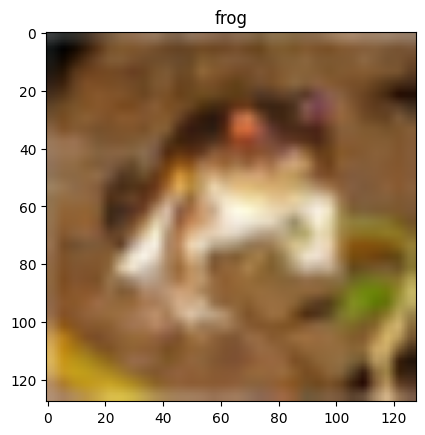

In [5]:
# Images are 32 x 32 pixels. 3 RGB channels.
print("Image size:", cifar_dataset[0][0].size())
cifar_dataset.display_image(index=0, resize=128)

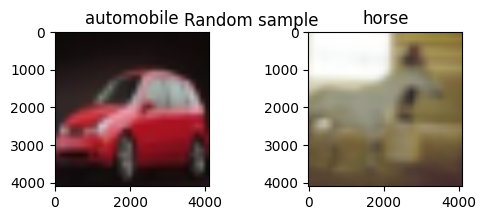

In [9]:
cifar_dataset.display_sample_images(sample_size=2, resize=1024*4)

## Augmentation techniques

#### Add noise to data

In [9]:
class GaussianNoise(object):
    """
    Class used for adding Gaussian noise to image. 
    Use after transforms.ToTensor(), if used in transforms.Compose() pipeline. 
    """
    def __init__(self, mean=0., std=0.05):
        self.std = std
        self.mean = mean
        
    def __call__(self, img):
        return img + torch.randn(tuple(img.size())) * self.std + self.mean

#### Dictionary for important techniques

In [10]:
# Easy to copy from, when certain technique is needed
augmentation = {'Rotation': transforms.RandomRotation(degrees=(-45,45)),
                'Cropping': transforms.RandomCrop(size=20),
                'ColorTranslation': transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                'Noise' : GaussianNoise(mean=0, std=0.1),
                'Flip': [transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip()],
                'RandomApply': transforms.RandomApply([], p=0.5)}

#### Random transforms combined with non-random transforms

In [11]:
# Transformations performed at random (with probability 0.5)
random_transforms = transforms.RandomApply([
                                  transforms.RandomRotation(degrees=(-90,90)),
                                  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.7, hue=0.1)], p=0.5)

# Transformations that are always performed
non_random_transforms = transforms.Compose([transforms.RandomCrop(25), transforms.ToTensor(), GaussianNoise()])

# transformer combines both previous transforming objects.
transformer = transforms.Compose([random_transforms, non_random_transforms])
cifar_dataset_augmented = CifarDataset(root_dir = ROOT_DIR, labels=LABELS, transform=transformer, class_dict=CLASS_DICT)

#### Sample images after transformations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

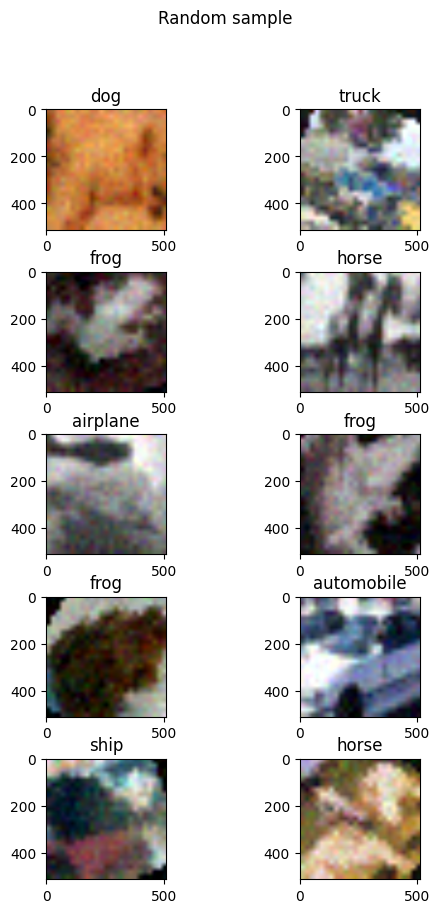

In [12]:
cifar_dataset_augmented.display_sample_images(sample_size=10, resize=512)